# Linear Classifier using PyTorch

In this notebook we train a linear classifier on the MINST dataset.

In [26]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

## Load the MNIST dataset 

In [27]:
# Load the datasets
train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [28]:
train_set[3][0].shape

torch.Size([1, 28, 28])

Create some Data Loaders for easy iteration during training. Initialise an array with the 10 class IDs.

In [29]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=64,
    shuffle=True,
    num_workers=4
)


test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=128, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=4
)

classes = np.arange(0, 10)

In [30]:
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Set the device to GPU if a GPU device is found.

In [31]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

Show some images and labels as a sanity check.
Use `torchvision.utils.make_grid` to create one image from a set of images. Note that this function converts single channel (grey-scale) tensors to have three channels. This is done by replicating the values into red, green and blue channels.

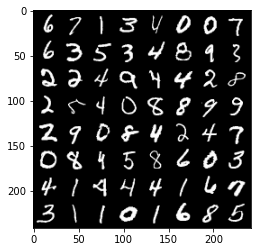

tensor([6, 7, 1, 3, 4, 0, 0, 7, 6, 3, 5, 3, 4, 8, 9, 3, 2, 2, 4, 9, 4, 4, 2, 8,
        2, 5, 4, 0, 8, 8, 9, 9, 2, 9, 0, 8, 4, 2, 4, 7, 0, 8, 4, 5, 8, 6, 0, 3,
        4, 1, 4, 4, 4, 1, 6, 7, 3, 1, 1, 0, 1, 6, 8, 5])


In [32]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
    return xa
    
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images and labels
timshow(torchvision.utils.make_grid(images))

# print(' '.join('%5s' % classes[labels[j]] for j in range(16)))  # displays just the scalars  
print(labels)


## Build a linear classifier
Instead of defining the classifier function, loss function and parameter updates directly as we did in PyTorch.ipynb, it is convenient to use the `torch.nn` and `torch.optim` packages. These provide a simple way to build networks without losing sight of the iterative steps in gradient descent.

First we construct the linear classifer function using the nn.Sequential wrapper that simply sequences the steps in the classifier function. In the case of a linear classifier there is just one nn.Linear layer. This is preceeded by `nn.Flatten` that flattens the input images into vectors.

In [33]:
single_layer_net = nn.Sequential(
    nn.Flatten(),
    
    # single layer
    nn.Linear(28*28, 10)

).to(device)

for param in single_layer_net.parameters():
    print(param.shape)


torch.Size([10, 784])
torch.Size([10])


Define a function to train the network.

In [34]:

def train_network(net, nepochs):

    losses = np.zeros(nepochs)
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(nepochs):  # loop over the dataset multiple times

        running_loss = 0.0
        n = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

             # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward, backward, and update parameters
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

           # with torch.no_grad():
               # for param in model.parameters():
               #     param -= learning_rate * param.grad
                    #print(param)

                 # accumulate loss
            running_loss += loss.item()
            n += 1

        losses[epoch] = meanloss = running_loss / n
        print(f"epoch: {epoch+1} loss: {meanloss : .3f}")

    print(f"input size: {inputs.size()}, output size: {outputs.size()}")

    return losses


Train the single layer network.

In [35]:
losses_single_layer = train_network(single_layer_net, 50)

epoch: 1 loss:  0.984
epoch: 2 loss:  0.551
epoch: 3 loss:  0.472
epoch: 4 loss:  0.433
epoch: 5 loss:  0.409
epoch: 6 loss:  0.392
epoch: 7 loss:  0.380
epoch: 8 loss:  0.370
epoch: 9 loss:  0.362
epoch: 10 loss:  0.355
epoch: 11 loss:  0.349
epoch: 12 loss:  0.344
epoch: 13 loss:  0.340
epoch: 14 loss:  0.336
epoch: 15 loss:  0.332
epoch: 16 loss:  0.329
epoch: 17 loss:  0.326
epoch: 18 loss:  0.323
epoch: 19 loss:  0.321
epoch: 20 loss:  0.319
epoch: 21 loss:  0.317
epoch: 22 loss:  0.315
epoch: 23 loss:  0.313
epoch: 24 loss:  0.311
epoch: 25 loss:  0.310
epoch: 26 loss:  0.308
epoch: 27 loss:  0.307
epoch: 28 loss:  0.305
epoch: 29 loss:  0.304
epoch: 30 loss:  0.303
epoch: 31 loss:  0.302
epoch: 32 loss:  0.301
epoch: 33 loss:  0.300
epoch: 34 loss:  0.299
epoch: 35 loss:  0.298
epoch: 36 loss:  0.297
epoch: 37 loss:  0.296
epoch: 38 loss:  0.295
epoch: 39 loss:  0.294
epoch: 40 loss:  0.294
epoch: 41 loss:  0.293
epoch: 42 loss:  0.292
epoch: 43 loss:  0.291
epoch: 44 loss:  0.2

Define a function to test the accuracy of the trained network on the test set.

In [36]:
def test_network(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            temp = (predicted == labels)
            correct += temp.sum().item()  # add in the number of correct labels

    print(f"Accuracy of the network on the test images: {correct/total : .1%}")

Test the accuracy for the single layer network.

In [37]:
test_network(single_layer_net)

Accuracy of the network on the test images:  92.1%


Now let's create a network with 2 layers.


In [48]:
two_layer_net = nn.Sequential(
    nn.Flatten(),

    # two layers
    nn.Linear(28*28, 300),
    nn.ReLU(),
    nn.Linear(300,10)
).to(device)

for param in two_layer_net.parameters():
    print(param.shape)

torch.Size([300, 784])
torch.Size([300])
torch.Size([10, 300])
torch.Size([10])


Train the 2 layer network.


In [49]:
losses_2_layers = train_network(two_layer_net, 50)

epoch: 1 loss:  1.228
epoch: 2 loss:  0.485
epoch: 3 loss:  0.388
epoch: 4 loss:  0.348
epoch: 5 loss:  0.324
epoch: 6 loss:  0.306
epoch: 7 loss:  0.291
epoch: 8 loss:  0.278
epoch: 9 loss:  0.267
epoch: 10 loss:  0.256
epoch: 11 loss:  0.246
epoch: 12 loss:  0.237
epoch: 13 loss:  0.229
epoch: 14 loss:  0.221
epoch: 15 loss:  0.213
epoch: 16 loss:  0.206
epoch: 17 loss:  0.200
epoch: 18 loss:  0.193
epoch: 19 loss:  0.188
epoch: 20 loss:  0.182
epoch: 21 loss:  0.176
epoch: 22 loss:  0.171
epoch: 23 loss:  0.166
epoch: 24 loss:  0.162
epoch: 25 loss:  0.157
epoch: 26 loss:  0.153
epoch: 27 loss:  0.149
epoch: 28 loss:  0.146
epoch: 29 loss:  0.142
epoch: 30 loss:  0.138
epoch: 31 loss:  0.135
epoch: 32 loss:  0.132
epoch: 33 loss:  0.129
epoch: 34 loss:  0.126
epoch: 35 loss:  0.123
epoch: 36 loss:  0.120
epoch: 37 loss:  0.118
epoch: 38 loss:  0.116
epoch: 39 loss:  0.113
epoch: 40 loss:  0.111
epoch: 41 loss:  0.109
epoch: 42 loss:  0.107
epoch: 43 loss:  0.104
epoch: 44 loss:  0.1

Test the accuracy for the two layered network.

In [50]:
test_network(two_layer_net)

Accuracy of the network on the test images:  97.0%


Test accuracy per class.

In [51]:
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         outputs = net(images)
#         _, predicted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(4):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1
#
# for i in range(10):
#     print('Accuracy of %2s : %2d %%' % (
#         classes[i], 100 * class_correct[i] / class_total[i]))

Define a function to plot the history of the loss function during training (mean loss in each epoch). Takes 2 losses and plots a comparison.

In [52]:
def compare_losses(losses1, losses2, losses1_label, losses2_label):
    plt.plot(losses1, 'r', label = losses1_label, )
    plt.plot(losses2, 'g', label = losses2_label )
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.title('Training loss for 1 and 2 layer classifiers')
    plt.show()

Compare the losses for single and two layered networks.

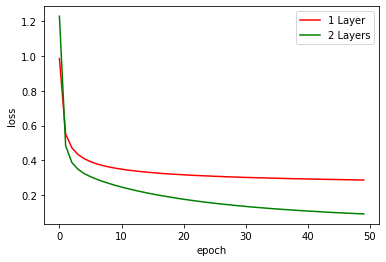

In [53]:
compare_losses(losses_single_layer, losses_2_layers, "1 Layer", "2 Layers")

In the above, we have used the 'container' module `nn.Sequential` to define our network. To give more flexibility in the definition of the network, we can define our own `nn.module`. Notice here, we have also performed the flattening ourselves.

In [ ]:
# class Classifier(nn.Module):
#
#     def __init__(self, num_classes=10):
#         super(LinearClassifier, self).__init__()
#         self.fc1 = nn.Linear(28 * 28, num_classes)
#
#     def forward(self, x):
#         out = x.reshape(x.size(0), -1) # flatten the input
#         out = self.fc1(out)
#         return out
#
# net = Classifier()
# print(net)

## Exercise
Experiment with the impact on accuracy of (1) adding a third fully-connected linear layer to the network and (2) replacing `nn.Sigmoid` by `nn.ReLU`.

### Task 1
Create a three layered network with ReLU as the activation function.

In [54]:
three_layer_network = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,300),
    nn.ReLU(),
    nn.Linear(300,100),
    nn.ReLU(),
    nn.Linear(100,10)
).to(device)

for param in three_layer_network.parameters():
    print(param.shape)

torch.Size([300, 784])
torch.Size([300])
torch.Size([100, 300])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


Train the three layered network.

In [55]:
losses_3_layers_ReLU = train_network(three_layer_network, 50)

epoch: 1 loss:  1.782
epoch: 2 loss:  0.564
epoch: 3 loss:  0.396
epoch: 4 loss:  0.340
epoch: 5 loss:  0.309
epoch: 6 loss:  0.286
epoch: 7 loss:  0.267
epoch: 8 loss:  0.251
epoch: 9 loss:  0.235
epoch: 10 loss:  0.222
epoch: 11 loss:  0.210
epoch: 12 loss:  0.198
epoch: 13 loss:  0.188
epoch: 14 loss:  0.178
epoch: 15 loss:  0.169
epoch: 16 loss:  0.161
epoch: 17 loss:  0.154
epoch: 18 loss:  0.147
epoch: 19 loss:  0.140
epoch: 20 loss:  0.135
epoch: 21 loss:  0.129
epoch: 22 loss:  0.124
epoch: 23 loss:  0.119
epoch: 24 loss:  0.114
epoch: 25 loss:  0.110
epoch: 26 loss:  0.105
epoch: 27 loss:  0.102
epoch: 28 loss:  0.098
epoch: 29 loss:  0.094
epoch: 30 loss:  0.091
epoch: 31 loss:  0.088
epoch: 32 loss:  0.085
epoch: 33 loss:  0.082
epoch: 34 loss:  0.079
epoch: 35 loss:  0.077
epoch: 36 loss:  0.074
epoch: 37 loss:  0.072
epoch: 38 loss:  0.069
epoch: 39 loss:  0.067
epoch: 40 loss:  0.065
epoch: 41 loss:  0.063
epoch: 42 loss:  0.061
epoch: 43 loss:  0.059
epoch: 44 loss:  0.0

Test the accuracy for the three layered network.

In [56]:
test_network(three_layer_network)

Accuracy of the network on the test images:  97.7%


Compare the losses for two and three layered networks.

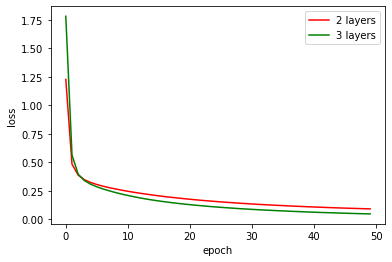

In [57]:
compare_losses(losses_2_layers, losses_3_layers_ReLU, "2 layers", "3 layers")

### Task 2
Create another three layered network with Sigmoid as the activation function.

In [58]:
three_layer_network_Sigmoid = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,300),
    nn.Sigmoid(),
    nn.Linear(300,100),
    nn.Sigmoid(),
    nn.Linear(100,10)
).to(device)

for param in three_layer_network_Sigmoid.parameters():
    print(param.shape)

torch.Size([300, 784])
torch.Size([300])
torch.Size([100, 300])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


Train the network.

In [59]:
losses_3_layers_Sigmoid = train_network(three_layer_network_Sigmoid, 50)

epoch: 1 loss:  2.299
epoch: 2 loss:  2.291
epoch: 3 loss:  2.281
epoch: 4 loss:  2.262
epoch: 5 loss:  2.223
epoch: 6 loss:  2.127
epoch: 7 loss:  1.907
epoch: 8 loss:  1.598
epoch: 9 loss:  1.331
epoch: 10 loss:  1.128
epoch: 11 loss:  0.977
epoch: 12 loss:  0.873
epoch: 13 loss:  0.796
epoch: 14 loss:  0.735
epoch: 15 loss:  0.683
epoch: 16 loss:  0.638
epoch: 17 loss:  0.598
epoch: 18 loss:  0.564
epoch: 19 loss:  0.535
epoch: 20 loss:  0.510
epoch: 21 loss:  0.489
epoch: 22 loss:  0.471
epoch: 23 loss:  0.456
epoch: 24 loss:  0.442
epoch: 25 loss:  0.431
epoch: 26 loss:  0.420
epoch: 27 loss:  0.411
epoch: 28 loss:  0.403
epoch: 29 loss:  0.395
epoch: 30 loss:  0.388
epoch: 31 loss:  0.382
epoch: 32 loss:  0.377
epoch: 33 loss:  0.371
epoch: 34 loss:  0.367
epoch: 35 loss:  0.362
epoch: 36 loss:  0.358
epoch: 37 loss:  0.355
epoch: 38 loss:  0.351
epoch: 39 loss:  0.347
epoch: 40 loss:  0.344
epoch: 41 loss:  0.341
epoch: 42 loss:  0.338
epoch: 43 loss:  0.335
epoch: 44 loss:  0.3

Test the accuracy of the network.

In [60]:
test_network(three_layer_network_Sigmoid)

Accuracy of the network on the test images:  91.0%


Compare the losses for the three layered ReLU and Sigmoid networks.

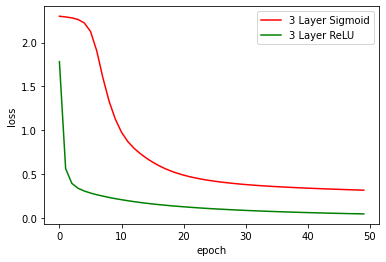

In [62]:
compare_losses(losses_3_layers_Sigmoid, losses_3_layers_ReLU, "3 Layer Sigmoid", "3 Layer ReLU")